In [1]:
import ROOT as r
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak
import mplhep


from sklearn.cluster import DBSCAN
import numba

Welcome to JupyROOT 6.22/00


In [2]:
# events_raw = uproot.open("../displacedJetMuon_ntupler_95.root")['ntuples/llp']
events_raw = uproot.open("~/eos/llp/zerobias18/displacedJetMuon_ntupler.root")['ntuples/llp']
df = coffea.processor.LazyDataFrame(events_raw,entrystop=10)
events = uproot.lazy(df._tree)

In [3]:
events.

<Array [{isData: False, nPV: 14, ... -666]}] type='1498 * {"isData": bool, "nPV"...'>

In [6]:
events.gLLP_decay_vertex_z

<Array [[-1.81e+03, -666], ... [-131, -666]] type='1526 * 2 * float32'>

In [9]:
nRechits = events.ncscRechits
eta,phi = events.cscRechitsEta, events.cscRechitsPhi
time = events.cscRechitsTwire
X = ak.zip({
    'n':nRechits,
    "eta":eta,
    "phi":phi,
    'time':time
})

llp =ak.zip({
    'pt':events.gLLP_pt,
    'eta':events.gLLP_eta,
    'phi':events.gLLP_phi,
    'energy':events.gLLP_e,
    },with_name='PtEtaPhiELorentzVector',
    behavior=vector.behavior
)

In [19]:
ak.flatten(llp[llp.energy>0].energy)

<Array [35.1, 119, 33.5, ... 24.4, 1.19e+03] type='1498 * float32'>

In [11]:
ak.any(events.gLLP_csc,axis=1)

<Array [False, False, False, ... False, False] type='1498 * bool'>

In [46]:
# X= X[ak.num(X,axis=1)>0]
# llp = llp[ak.num(X,axis=1)>0]

def DBScan(X,nCore,eps):
    points=ak.zip([X.eta,X.phi],highlevel=False)

    nCS=[]
    masks=[]
    etas=[]
    phis=[]
    etas_sd=[]
    phis_sd=[]
    width=[]
    size=[]
    for x in points:
        cl_eta=[]
        cl_phi=[]
        cl_size=[]
        cl_eta_sd=[]
        cl_phi_sd=[]
        cl_width=[]
        n_clusters_=0
        core_samples_mask=[]
        x=np.stack(ak.unzip(x),axis=1)## format into DBSCAN x=[ [x1,y1],[x2,y2] ... ]
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #         print(labels,set(labels),n_clusters_)
            for iCs in range(n_clusters_):
                rh_eta=x[labels==iCs][:,0]
                rh_phi=x[labels==iCs][:,1]            
                cl_eta.append(np.mean(rh_eta))
                cl_phi.append(np.mean(rh_phi))            
                cl_eta_sd.append(np.std(rh_eta))
                cl_phi_sd.append(np.std(rh_phi))                            
                cl_width.append((np.std(rh_phi)**2+np.std(rh_eta)**2)**0.5)
                cl_size.append(len(rh_eta))
        nCS.append(n_clusters_)
        masks.append(core_samples_mask)
        etas.append(cl_eta)
        phis.append(cl_phi)
        etas_sd.append(cl_eta_sd)
        phis_sd.append(cl_phi_sd)
        width.append(cl_width)
        size.append(cl_size)
    return np.array(nCS),ak.Array(etas),ak.Array(phis),ak.Array(size),ak.Array(etas_sd),ak.Array(phis_sd),ak.Array(width)  

def CAcluster(X,dR=1.0,nCore=50):
    vectors=ak.zip({
        'pt':ak.ones_like(X.phi),
        'eta':X.eta,
        'phi':X.phi,
        'mass':ak.zeros_like(X.phi)
    })
    cls_eta=[]
    cls_phi=[]
    cls_size=[]
    ncls   =[]
    cls_eta_sd=[]
    cls_phi_sd=[]
    cls_width=[]    
    for v in vectors:
        v = ak.to_numpy(v)
        v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                     dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
        clusterVals = cluster(v,R=dR,algo="cambridge")
        #include all rechits with ptmin=0
        _jets = clusterVals.inclusive_jets(ptmin=0)
        etas=[j.eta for j in _jets if len(j)>=nCore]
        phis=[j.phi for j in _jets if len(j)>=nCore]
        etas_sd=[]
        phis_sd=[]        
        width = []
        for jet in _jets:
            if len(jet)<nCore:continue
            eta_sd = np.std(np.array([p.eta for p in jet]))
            phi_sd = np.std(np.array([p.phi for p in jet]))            
            etas_sd.append(eta_sd)    
            phis_sd.append(phi_sd)                
            width.append((phi_sd**2+eta_sd**2)**0.5)                            
        cls_eta.append(etas)
        cls_phi.append(phis)
        cls_eta_sd.append(etas_sd)
        cls_phi_sd.append(phis_sd)
        cls_width.append(width)        
        cls_size.append([len(j) for j in _jets if len(j)>=nCore])            
        ncls.append(len([j.eta for j in _jets if len(j)>=nCore]))
    return np.array(ncls),ak.Array(cls_eta),ak.Array(cls_phi),ak.Array(cls_size),ak.Array(cls_eta_sd),ak.Array(cls_phi_sd),ak.Array(cls_width)

In [50]:
np.where(CA_nCS>1)

(array([81]),)

In [49]:
print(ak.to_list(CA_size[CA_nCS>1]))
print(ak.to_list(CA_eta[CA_nCS>1]))
print(ak.to_list(CA_eta_sd[CA_nCS>1]))
print(ak.to_list(CA_width[CA_nCS>1]))

[[335, 71]]
[[-1.3624600964418159, -1.6524322228035644]]
[[0.05019582898564063, 0.04969725672334734]]
[[0.06378969597229253, 0.06447263704154461]]


In [52]:
ak.flatten(CA_size)

<Array [53, 50, 335, 71, ... 50, 61, 76, 50] type='61 * int64'>

In [ ]:
bins=[0,100,200,300]


In [47]:
db_nCS,db_eta,db_phi,db_size,db_eta_sd,db_phi_sd,db_width = DBScan(X,50,0.2)
CA_nCS,CA_eta,CA_phi,CA_size,CA_eta_sd,CA_phi_sd,CA_width = CAcluster(X,0.2,50)

db_cls=ak.zip({
    'pt':ak.ones_like(db_phi),
    'eta':db_eta,
    'phi':db_phi,
    'mass':ak.zeros_like(db_phi)
},with_name='PtEtaPhiMLorentzVector',
behavior=vector.behavior
)
CA_cls=ak.zip({
    'pt':ak.ones_like(CA_phi),
    'eta':CA_eta,
    'phi':CA_phi,
    'mass':ak.zeros_like(CA_phi)
},with_name='PtEtaPhiMLorentzVector',
behavior=vector.behavior    
)


In [48]:
print("events with >1 cluster for DBScan =", np.where(db_nCS>1))
print("nCS with >1 cluster for DBScan    = "   ,db_nCS[db_nCS>1])
print("nCS with >1 cluster for CA       = "   ,CA_nCS[db_nCS>1])
print("size with >1 cluster for DBScan    = "   ,db_size[db_nCS>1])
print("width with >1 cluster for DBScan    = "   ,db_width[db_nCS>1])
print("size with >1 cluster for CA       = "   ,CA_size[db_nCS>1])
print("events with >1 cluster for CA    ="    , np.where(CA_nCS>1))
print("nCS with >1 cluster for CA       = "   ,CA_nCS[CA_nCS>1])
print("nCS with >1 cluster for DBScan   = "   ,db_nCS[CA_nCS>1])
print("size with >1 cluster for CA       = "   ,CA_size[CA_nCS>1])
print("size with >1 cluster for DBScan   = "   ,db_size[CA_nCS>1])

events with >1 cluster for DBScan = (array([1254]),)
nCS with >1 cluster for DBScan    =  [2]
nCS with >1 cluster for CA       =  [1]
size with >1 cluster for DBScan    =  [[54, 551]]
width with >1 cluster for DBScan    =  [[0.0989, 0.107]]
size with >1 cluster for CA       =  [[551]]
events with >1 cluster for CA    = (array([81]),)
nCS with >1 cluster for CA       =  [2]
nCS with >1 cluster for DBScan   =  [1]
size with >1 cluster for CA       =  [[335, 71]]
size with >1 cluster for DBScan   =  [[409]]


In [14]:
llp_CA = ak.cartesian({"ca": CA_cls,"llp":llp}, nested=True, axis=1)
llp_db = ak.cartesian({"db": db_cls,"llp":llp}, nested=True, axis=1)

cls_pairs_DB = ak.cartesian({"db": db_cls, "ca": CA_cls}, nested=True, axis=1)
cls_pairs_CA = ak.cartesian({"ca": CA_cls, "db": db_cls}, nested=True, axis=1)
print(cls_pairs_DB.db.delta_r(cls_pairs_DB.ca)[1124])
print(cls_pairs_CA.ca.delta_r(cls_pairs_CA.db)[1124])

[[0.15], [0.0574]]
[[0.15, 0.0574]]


In [15]:
dR_CA = cls_pairs_CA.ca.delta_r(cls_pairs_CA.db)
ak.flatten(ak.values_astype(ak.any(dR_CA<0.1,axis=2),np.int))


<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='66 * int64'>

In [16]:
dR_llp_CA = llp_CA.ca.delta_r(llp_CA.llp)
dR_llp_db = llp_db.db.delta_r(llp_db.llp)

In [23]:
print(CA_nCS[489])
print(CA_size[489])
print((dR_llp_CA)[489])
print((dR_llp_CA<0.2)[489])

print(ak.any(dR_llp_CA<0.2,axis=2)[489])
print(ak.values_astype(ak.any(dR_llp_CA<0.2,axis=2),np.int)[489])
matched =ak.any(dR_llp_CA<0.2,axis=2)
print(CA_size[matched][489])
print(ak.to_list(llp[matched][489]))

3
[320, 88, 80]
[[0.0143, 664], [0.186, 664], [0.22, 664]]
[[True, False], [True, False], [False, False]]
[True, True, False]
[1, 1, 0]
[320, 88]
[{'pt': 21.005844116210938, 'eta': -2.2478251457214355, 'phi': -0.12557795643806458, 'energy': 100.66612243652344}, {'pt': -666.0, 'eta': -666.0, 'phi': -666.0, 'energy': -666.0}]


In [57]:
np.where(CA_nCS>1)

(array([ 489,  740, 1434]),)

In [50]:
ak.to_list(llp[489])

[{'pt': 21.005844116210938,
  'eta': -2.2478251457214355,
  'phi': -0.12557795643806458,
  'energy': 100.66612243652344},
 {'pt': -666.0, 'eta': -666.0, 'phi': -666.0, 'energy': -666.0}]

In [48]:
ak.to_list(dR_llp_CA[489])

[[0.01430938860392285, 663.7388626810731],
 [0.18635305778759811, 663.9372939560155],
 [0.2197735459411559, 663.7395952057981]]

In [45]:
ak.any(dR_llp_CA<0.2,axis=2)

<Array [True, True, False] type='3 * bool'>

In [46]:
CA_cls.phi[489]

<Array [-0.131, -0.147, -0.345] type='3 * float64'>

In [24]:
ak.to_list(dR_llp_db[db_nCS>=1])

[[[2.9841224395310615, 668.2882926846145]],
 [[0.058298796452494604, 664.6227109624415]],
 [[0.04608232138394123, 667.4327470016588]],
 [[2.53705559275484, 663.7050614745666]],
 [[2.1215562233791223, 663.6875268271887]],
 [[1.9340824127511516, 668.3752715063372]],
 [[3.8733635865070433, 663.7458931919281]],
 [[4.704384419970469, 664.1170253328139]],
 [[0.6000524743499359, 664.0152852810653]],
 [[2.2987996394868473, 664.1504330616884]],
 [[0.009606468867603479, 667.2421284735194]],
 [[2.1893377750108707, 663.7320439728602]],
 [[2.820126125355832, 664.6486801780142]],
 [[2.7503354781484894, 664.320441417463]],
 [[1.1390945903763725, 663.7303553841404]],
 [[2.8964198865942694, 668.1685046778931]],
 [[5.611906853710468, 668.2223780513858]],
 [[1.4585989507953818, 667.4284342223575]],
 [[0.09342879463037619, 667.4508624211459]],
 [[0.05114991834103438, 668.0449553972605]],
 [[0.5843831640722105, 668.1486081246434]],
 [[4.189766121437689, 664.2350705514402]],
 [[6.340441153389864, 663.899392

In [30]:
llp_CA

[{'pt': 1.0,
  'eta': -2.261153914635823,
  'phi': -0.13078396464444886,
  'mass': 0.0},
 {'pt': 1.0,
  'eta': -2.0627264986045724,
  'phi': -0.14716390052895,
  'mass': 0.0},
 {'pt': 1.0,
  'eta': -2.2605038534623354,
  'phi': -0.3449854810710411,
  'mass': 0.0}]

In [28]:
CA_nCS[CA_nCS==0]

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
ak.flatten(ak.values_astype(ak.any(dR_CA<0.1,axis=1),np.int))

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='64 * int64'>

In [69]:
ak.flatten(CA_phi,axis=1)

<Array [1.02, -1.41, 0.883, ... -2.84, -1.93] type='66 * float64'>

In [173]:
ak.to_list(db_cls[db_nCS>1])[0]

[{'pt': 1.0, 'eta': 2.316718101501465, 'phi': 1.4758776426315308, 'mass': 0.0},
 {'pt': 1.0,
  'eta': 1.8627490997314453,
  'phi': 1.5360913276672363,
  'mass': 0.0}]

array([[(1.,  2.3167181 ,  1.47587764, 0.),
        (1.,  1.8627491 ,  1.53609133, 0.)],
       [(1.,  2.09076333, -3.0184145 , 0.),
        (1.,  2.1360743 ,  3.08646846, 0.)],
       [(1.,  2.28960228, -1.88145053, 0.),
        (1., -2.21798921, -2.84210038, 0.)]],
      dtype=[('pt', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8')])

In [ ]:
CA_cls[]

In [41]:
nCS,masks,eta,phi = DBScan(points,10,0.2)
print(nCS[0],eta[0],phi[0])

NameError: name 'points' is not defined

In [46]:
# masks = masks[nCS>0]
# X = X[nCS>0]
DB_phi = ak.fill_none(ak.mean(X[masks].phi,axis=1),-99)
DB_eta = ak.mean(X[masks].eta,axis=1)   

In [48]:
DB_phi[14]

-99.0

In [23]:
np.where(nCS==0)

(array([  14,   42,   45,   48,   75,   89,   92,   98,   99,  103,  105,
         109,  112,  115,  117,  119,  120,  123,  127,  129,  130,  141,
         143,  150,  154,  158,  160,  164,  168,  187,  194,  217,  229,
         236,  237,  238,  243,  245,  246,  252,  263,  267,  276,  279,
         289,  306,  320,  321,  322,  326,  341,  345,  349,  351,  352,
         359,  361,  369,  372,  376,  384,  389,  393,  394,  396,  399,
         400,  408,  418,  419,  420,  429,  436,  439,  440,  441,  454,
         479,  480,  505,  507,  526,  543,  546,  548,  557,  559,  562,
         563,  564,  571,  577,  578,  585,  586,  588,  589,  590,  601,
         602,  607,  609,  619,  628,  645,  650,  651,  652,  657,  659,
         665,  680,  681,  688,  692,  697,  699,  704,  707,  712,  713,
         715,  717,  721,  724,  725,  729,  730,  736,  740,  745,  747,
         755,  757,  763,  764,  765,  767,  768,  775,  779,  811,  827,
         832,  847,  849,  850,  852, 

In [31]:
nCS[14]

0

In [35]:
ak.Array(X[nCS>=0],)

<Array [[{n: 76, eta: 2.42, ... time: 94.8}]] type='1524 * var * {"n": int32, "e...'>

In [38]:
X[nCS>0]

<Array [[{n: 76, eta: 2.42, ... time: 94.8}]] type='1290 * var * {"n": int32, "e...'>

In [33]:
a = ak.Array([[1,2,3],[3,4,5,6],[1,3,5]])
a[[True,False,False]]

<Array [[1, 2, 3]] type='1 * var * int64'>

In [33]:
x=(X[0:2])

In [73]:
masks[0]

<Array [False, False, False, ... False, False] type='76 * bool'>

In [7]:
ak.count_nonzero(masks,axis=1)

<Array [36, 1] type='2 * int64'>

In [66]:
np.where(masks[1])

(array([18]),)

In [77]:
t=x[masks].time

In [79]:
ak.mean(t,axis=1)

<Array [59.7, -78.2] type='2 * ?float64'>

In [4]:
X.phi[0:2],X.eta[0:2]

(<Array [[1.8, 1.76, 1.72, ... 1.31, 1.31, 1.4]] type='2 * var * float32'>,
 <Array [[2.42, 2.39, 2.38, ... -2.26, -2.06]] type='2 * var * float32'>)

In [2]:
vectors=ak.zip({
    'pt':ak.ones_like(X.phi[0:2])*0.1,
    'eta':X.eta[0:2],
    'phi':X.phi[0:2],
    'mass':ak.zeros_like(X.phi[0:2])
})

def CAcluster(vectors,dR=1.0,nCores=10):
    cls_eta=[]
    cls_phi=[]
    ncls   =[]
    jets=[]
    for v in vectors:
        v = ak.to_numpy(v)
        v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                     dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
        clusterVals = cluster(v,R=dR,algo="cambridge")
        _jets = clusterVals.inclusive_jets(ptmin=0)
        jets.append(_jets)
        cls_eta.append([j.eta for j in _jets if len(j)>nCores])
        cls_phi.append([j.phi for j in _jets if len(j)>nCores])
        ncls.append(len([j.eta for j in _jets if len(j)>nCores]))
        
        for i,jet in enumerate(_jets):
            print("Jet %i: pt=%.3f phi=%.3f eta=%.3f"%(i, jet.pt, jet.phi, jet.eta))

    return np.array(ncls),jets

NameError: name 'ak' is not defined

In [8]:
ncls,jets = CAcluster(vectors,dR=1.0,nCores=10)
print(ncls)

[3 1]


In [1]:
jets[0][0]

NameError: name 'jets' is not defined

In [10]:
for iev in jets:
    s=0
    for jet in iev:
        print(len(jet))
#         for pjet in jet:
#             print(pjet)
        s+=len(jet)
    print('sum of jet con:',s)

32
18
12
5
4
4
1
sum of jet con: 76
12
10
2
sum of jet con: 24


In [16]:
vectors[1]

<Array [{pt: 1, eta: 2.37, ... mass: 0}] type='24 * {"pt": float32, "eta": float...'>

In [10]:
X.phi[0:2],X.eta[0:2]

(<Array [[1.8, 1.76, 1.72, ... 1.31, 1.31, 1.4]] type='2 * var * float32'>,
 <Array [[2.42, 2.39, 2.38, ... -2.26, -2.06]] type='2 * var * float32'>)

In [11]:
import numpy as np
import awkward as ak
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

In [15]:
vectors=ak.zip({
    'pt':ak.ones_like(X.phi[0:2])*0.1,
    'eta':X.eta[0:2],
    'phi':X.phi[0:2],
    'mass':ak.zeros_like(X.phi[0:2])
},with_name='PtEtaPhiMLorentzVector',
behavior=
)
vectors2=ak.zip({
    'pt':ak.ones_like(X.phi[2:4])*0.1,
    'eta':X.eta[2:4],
    'phi':X.phi[2:4],
    'mass':ak.zeros_like(X.phi[2:4])
},with_name='PtEtaPhiMLorentzVector'
)

In [46]:
vectors2.eta[0]

<Array [2.26, 2.27, 2.27, ... -1.52, -1.53] type='129 * float32'>

In [99]:
ak.to_list(ak.cartesian([vectors,vectors2],nested=True)[0])

[[({'pt': 0.10000000149011612,
    'eta': 2.4221129417419434,
    'phi': 1.8028720617294312,
    'mass': 0.0},
   {'pt': 0.10000000149011612,
    'eta': 2.264500379562378,
    'phi': 2.668238401412964,
    'mass': 0.0}),
  ({'pt': 0.10000000149011612,
    'eta': 2.4221129417419434,
    'phi': 1.8028720617294312,
    'mass': 0.0},
   {'pt': 0.10000000149011612,
    'eta': 2.265655994415283,
    'phi': 2.666335344314575,
    'mass': 0.0}),
  ({'pt': 0.10000000149011612,
    'eta': 2.4221129417419434,
    'phi': 1.8028720617294312,
    'mass': 0.0},
   {'pt': 0.10000000149011612,
    'eta': 2.2669320106506348,
    'phi': 2.6642253398895264,
    'mass': 0.0}),
  ({'pt': 0.10000000149011612,
    'eta': 2.4221129417419434,
    'phi': 1.8028720617294312,
    'mass': 0.0},
   {'pt': 0.10000000149011612,
    'eta': 2.2551870346069336,
    'phi': 2.662557601928711,
    'mass': 0.0}),
  ({'pt': 0.10000000149011612,
    'eta': 2.4221129417419434,
    'phi': 1.8028720617294312,
    'mass': 0.0},
  

In [87]:
len(ak.to_numpy(vectors2[1]))

41

In [32]:
vectors.eta[0][:10]-vectors2.eta[0][:10]

<Array [0.158, 0.12, 0.116, ... -0.378, -0.392] type='10 * float32'>

In [45]:
vectors[0][0].delta_r(vectors2[0][:10])

<Array [0.88, 0.878, 0.875, ... 2.47, 2.46] type='10 * float32'>

In [69]:
len(vectors2[1][0].cross(vectors[1]))

24

In [63]:
len(vectors2[1])

41

In [94]:
len(X)

1526

In [302]:
def DBScan(X,nCore,eps):
    points=ak.zip([X.eta,X.phi])
    alllabels=[]
    masks=[]
    data=[]
    for x in points:
        x=np.stack(ak.unzip(x),axis=1)## format into DBSCAN x=[ [x1,y1],[x2,y2] ... ]
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore,metric=dR).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #         print(labels,set(labels),n_clusters_)
#             for iCs in range(n_clusters_):
#                 rh_eta=x[labels==iCs][:,0]
#                 rh_phi=x[labels==iCs][:,1]            
            alllabels.append(labels)
            masks.append(core_samples_mask)    
            data.append(x)
    return alllabels,masks,data

def CAcluster(X,dR=1.0,nCore=50):
    vectors=ak.zip({
        'pt':ak.ones_like(X.phi),
        'eta':X.eta,
        'phi':X.phi,
        'mass':ak.zeros_like(X.phi)
    })  
    alljets=[]
    for v in vectors:
        v = ak.to_numpy(v)
        v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                     dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
        clusterVals = cluster(v,R=dR,algo="cambridge")
        #include all rechits with ptmin=0
        _jets = clusterVals.inclusive_jets(ptmin=0)
        alljets.append(_jets)
        
    return alljets

In [305]:
alljets= CAcluster(X[[ 489,  740,1124, 1434]],dR=0.2,nCore=50)
alllabels,allmasks,alldata= DBScan(X[[ 489,  740, 1124,1434]],eps=0.2,nCore=50)

In [308]:
labels=alllabels[0]
core_samples_mask=allmasks[0]
data = alldata[0]


import matplotlib.pyplot as plt

def plot(index):
    ms = 10
    
    labels=alllabels[index]
    core_samples_mask=allmasks[index]
    data = alldata[index]
    jets=alljets[index]
    
    ncols=2
    nrows=1
    figsize=(8,4)
    fig, axs = plt.subplots(1,2,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])    
    axs = axs.flatten()
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        ## cores
        xy = data[class_member_mask & core_samples_mask]
        axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=ms)
        ## noise
        xy = data[class_member_mask & ~core_samples_mask]
        axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=1)

    nCAjets=len([1 for j in jets if len(j)>50])
    colors = [plt.cm.Spectral(each)for each in np.linspace(0, 1, nCAjets)]        
    for j in jets:
        if len(j)>50:
            col=colors.pop(0)
        else:
            col=[0, 0, 0, 1]
        x = [p.eta for p in j]
        y = [p.phi for p in j]        
        if len(j)>50:
            axs[1].plot(x, y, 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=ms)
#             print(j.eta,j.phi)
#             circle = plt.Circle((j.eta, j.phi), 0.2, color='b', fill=False)                
#             axs[1].add_artist(circle)
        else:
            axs[1].plot(x, y, 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=1)        
        
    axs[0].set_title('Estimated number of DB clusters: %d' % n_clusters_)
    axs[0].set_xlabel('eta')
    axs[0].set_ylabel('phi')    
    axs[1].set_title('Estimated number of CA clusters: %d' % nCAjets)
    axs[1].set_xlabel('eta')
    axs[1].set_ylabel('phi')        
    plt.show()

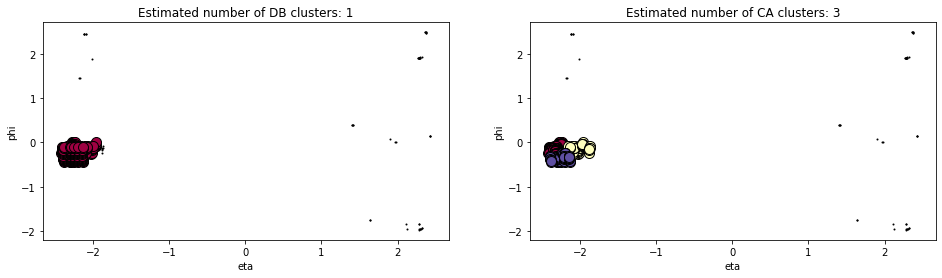

In [309]:
plot(0)

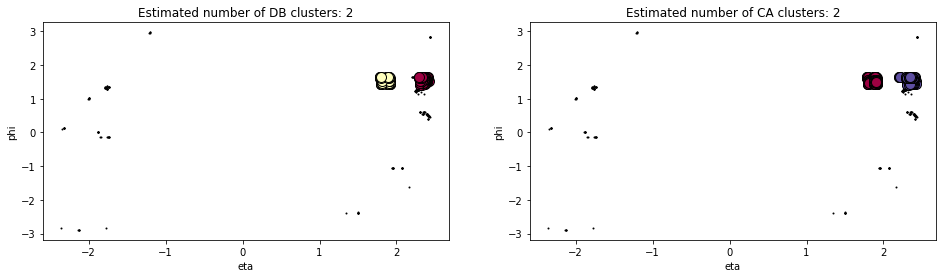

In [310]:
plot(1)

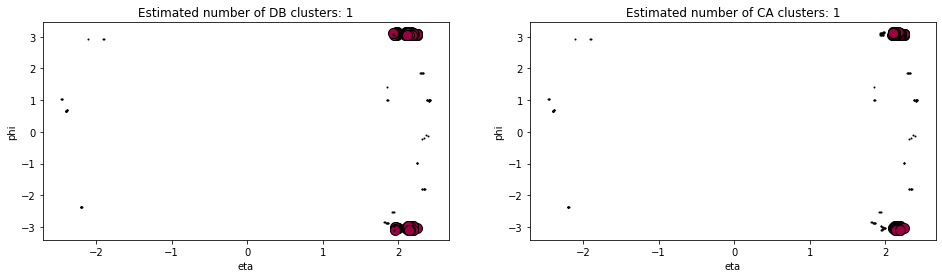

In [311]:
plot(2)

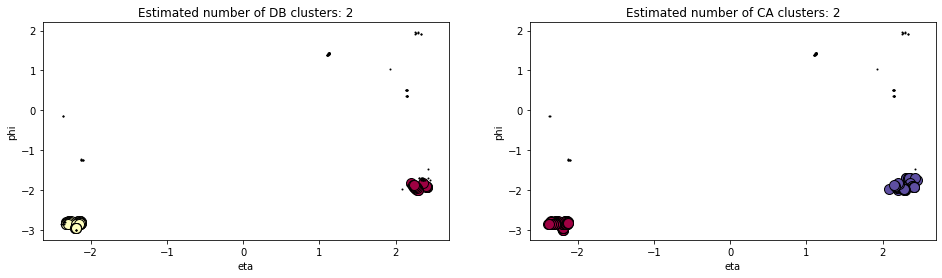

In [223]:
plot(3)

In [275]:
len(X)

1526

In [304]:
# test = X[[ 489, 740,1124, 1434]]
test = X[[489, 740]]
points =ak.zip([test.eta,test.phi])
for x in points:
    x=np.stack(ak.unzip(x),axis=1)
    print(x[0])
def dR(x,y):
    dphi=(x[1]-y[1] +np.pi) %(2*np.pi)-np.pi
    deta=(x[0]-y[0])    
    return (dphi**2+deta**2)**0.5

[2.3763185 2.4754224]
[2.398375  0.5395927]


In [294]:
np.stack(ak.unzip(points[0]),axis=1)[0]

array([2.3763185, 2.4754224], dtype=float32)